## General Parameter Setting

In [91]:
import qiskit_aer.noise as noise

# Error probabilities
prob_1 = 0.001   # 1-qubit gate
prob_2 = 0.01    # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
# noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

## Function Def.

In [56]:
from qiskit import QuantumCircuit

# n-qubit GHZ generator circuit
def gen_nGHZ_circ(num_qubit=2):
    # Set num_qubit >= 2
    try:
        if num_qubit<2:
            raise Exception("Nonvalid num_qubit")
    except Exception as e:
        raise ValueError(e)
    
    # n-qubit GHZ circuit
    circ = QuantumCircuit(num_qubit, num_qubit)
    circ.h(0)
    
    for i in range(num_qubit-1):
        circ.cx(0, i+1)
    
    circ.barrier()
    circ.measure(range(num_qubit), range(num_qubit))
    
    return circ

In [88]:
circ = gen_nGHZ_circ(num_qubit=3)
circ.draw()

┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────■───░─┤M├──────
     └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ─────┤ X ├──┼───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2

In [84]:
from qiskit import QuantumCircuit
from numpy import pi

# n-qubit GHZ generator circuit (with error rejection)
def gen_nGHZ_ER_circ(num_qubit=2):
    # Set num_qubit >= 2
    try:
        if num_qubit<2:
            raise Exception("Nonvalid num_qubit")
    except Exception as e:
        raise ValueError(e)
    
    # n-qubit GHZ circuit (ER encoded)
    encoded_qubit = 1
    ancilla_qubit = 1
    tot_qubit = num_qubit + encoded_qubit + ancilla_qubit
    
    circ = QuantumCircuit(tot_qubit, tot_qubit)
    
    # Logical Hadamard gate
    circ.h(1)
    circ.cry(pi,1,0)
    circ.h([0,1])
    
    for i in range(num_qubit-1):
        circ.cx(0, i + 1 + encoded_qubit + ancilla_qubit)
    
    # Error rejection part
    circ.barrier()
    circ.cx(0, encoded_qubit + ancilla_qubit)
    circ.cx(1, encoded_qubit + ancilla_qubit)
    
    circ.barrier()
    circ.measure(range(tot_qubit), range(tot_qubit))
    
    return circ

In [87]:
circ = gen_nGHZ_ER_circ(num_qubit=3)
circ.draw()

┌───────┐┌───┐           ░            ░ ┌─┐            
q_0: ─────┤ Ry(π) ├┤ H ├──■────■───░───■────────░─┤M├────────────
     ┌───┐└───┬───┘├───┤  │    │   ░   │        ░ └╥┘┌─┐         
q_1: ┤ H ├────■────┤ H ├──┼────┼───░───┼────■───░──╫─┤M├─────────
     └───┘         └───┘  │    │   ░ ┌─┴─┐┌─┴─┐ ░  ║ └╥┘┌─┐      
q_2: ─────────────────────┼────┼───░─┤ X ├┤ X ├─░──╫──╫─┤M├──────
                        ┌─┴─┐  │   ░ └───┘└───┘ ░  ║  ║ └╥┘┌─┐   
q_3: ───────────────────┤ X ├──┼───░────────────░──╫──╫──╫─┤M├───
                        └───┘┌─┴─┐ ░            ░  ║  ║  ║ └╥┘┌─┐
q_4: ────────────────────────┤ X ├─░────────────░──╫──╫──╫──╫─┤M├
                             └───┘ ░            ░  ║  ║  ║  ║ └╥┘
c: 5/══════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                   0  1  2  3  4

In [157]:
# Post processing step for error rejection
# : Select "0" result on ancilla part, must be same result in encoded qubits
def nGHZ_ER_postprocessing(counts):

    # Post processed counts
    counts_pp = {}
    
    # Select proper key and adjust
    for key, value in counts.items():
        if (key[len(key)-1]==key[len(key)-2]) and (key[len(key)-3]=='0'):
            counts_pp[key[0:len(key)-3] + key[len(key)-1]] = value
    
    return counts_pp

In [318]:
import math as ma

def pd_similarity(counts):
    
    # Get total counts
    total_count = 0
    for value in counts.values():
        total_count += value
        
    # Converts to probability distribution
    for key, value in counts.items():
        st_len = len(key)
        counts[key] = value/total_count
    
    # List of ordered value
    for i in range(int(ma.pow(2,st_len))):
        binary = (bin(i)[2:].zfill(st_len))
        if binary not in list(counts):
            counts[binary] = 0
    counts = sorted(counts.items())       
    
    # Construct ideal probability distribution
    st0 = ""
    for i in range(st_len):
        st0 += "0"
    st1 = ""
    for i in range(st_len):
        st1 += "1"
    counts_id = {st0: 1/2, st1: 1/2}
    
    # List of ordered value
    for i in range(int(ma.pow(2,st_len))):
        binary = (bin(i)[2:].zfill(st_len))
        if binary not in list(counts_id):
            counts_id[binary] = 0
    counts_id = sorted(counts_id.items())       
    
    
    # Calculate similarity
    similarity = 0
    for i in range(int(ma.pow(2,st_len))):
        similarity += pow(counts[i][1] - counts_id[i][1], 2)
    similarity = similarity/int(ma.pow(2,st_len))
    
    return similarity

## Execution Part

In [338]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram, plot_distribution

# Perform a noise simulation
result = execute(gen_nGHZ_circ(num_qubit=4), 
                 Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                 shots=1000).result()
counts_nGHZ = result.get_counts()
print(counts_nGHZ)
plot_distribution(counts_nGHZ)
print(pd_similarity(counts_nGHZ))

{'1000': 2, '0000': 504, '1111': 476, '0010': 3, '1011': 3, '1101': 8, '0111': 1, '0001': 2, '0110': 1}
4.275000000000006e-05


In [339]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram, plot_distribution

# Perform a noise simulation
result = execute(gen_nGHZ_ER_circ(num_qubit=4), 
                 Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                 shots=1000).result()
counts_nGHZ_ER = result.get_counts()

# Post processing
counts_pp_nGHZ_ER = nGHZ_ER_postprocessing(counts_nGHZ_ER)

print(counts_pp_nGHZ_ER)
plot_distribution(counts_pp_nGHZ_ER)
pd_similarity(counts_pp_nGHZ_ER)

{'1111': 475, '0000': 474, '1011': 1, '0111': 1, '0100': 4, '0010': 1}


3.0089634285114205e-06

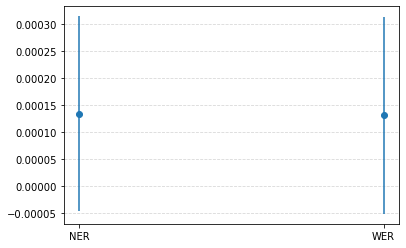

In [353]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 2
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

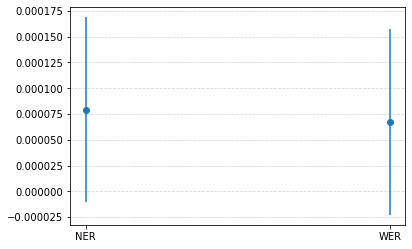

In [354]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 3
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

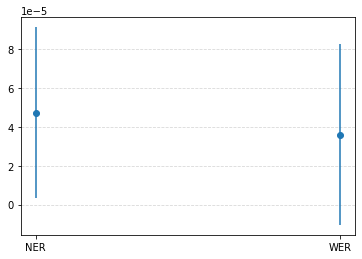

In [355]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 4
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

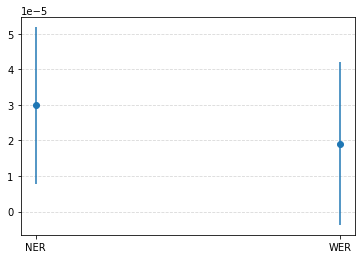

In [356]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 5
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

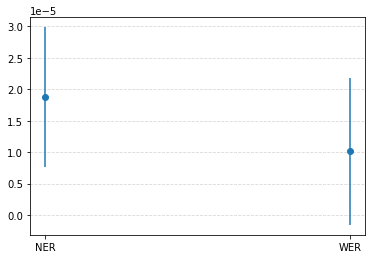

In [357]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 6
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

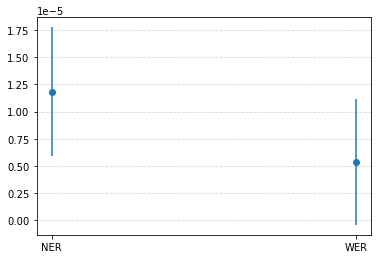

In [358]:
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

# Initial variable setting
num_qubit = 7
rep = 10000
shots = 1000
pd_sim_ner = []
pd_sim_wer = []

# Collecting results
for x in range(rep):
    # Perform a noise simulation (no error rejection)
    result_ner = execute(gen_nGHZ_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_ner.append(pd_similarity(result_ner.get_counts()))
    
    # Perform a noise simulation (with error rejection)
    result_wer = execute(gen_nGHZ_ER_circ(num_qubit), 
                     Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,
                     shots=shots).result()
    pd_sim_wer.append(pd_similarity(nGHZ_ER_postprocessing(result_wer.get_counts())))
    
# Analysis
means = [np.mean(pd_sim_ner), np.mean(pd_sim_wer)]
std = [np.std(pd_sim_ner), np.std(pd_sim_wer)]

plt.errorbar(["NER", "WER"], means, yerr=std, fmt='o')
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()